In [1]:
import pandas as pd
import plotnine as pn
import patchworklib as pw
print(pw.__version__)
print(pn.__version__)

0.5.0
0.10.1


<Figure size 100x100 with 0 Axes>

## Read data

In [2]:
# Constants for paper
params = [
    0, 1, 2, 4, 8, 16,
]

In [3]:
# Filepaths

#############################################################################
# Analysis files
#############################################################################

# Pareto frontier
curve_fn = f"/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/distortion=squared_dist/curve_points.csv"

# Counterpart points
counterpart_fn = f"/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/distortion=squared_dist/counterpart_points.csv"

# Counterpart trajectories
counterpart_traj_fn = f"/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/distortion=squared_dist/counterpart_trajectories.csv"

#############################################################################
# Simulation points
#############################################################################
rl_fns = {
    f"{float(param)}":f"/Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/distortion=squared_dist/similarity=nosofsky_normed/dynamics=reinforcement_learning/num_trials=100/sim_param={param}/simulation_points.csv"
    for param in params
}

# Reinforcement learning paths
rl_variant_fns = {
    key: val.replace("simulation_points", "variants_points") for key, val in rl_fns.items()
}

rl_traj_fns = {
    key: val.replace("simulation_points", "mean_points") for key, val in rl_fns.items()
}

# Replicator dynamic paths
rep_fns = {
    key: value.replace("reinforcement_learning", "replicator_dynamic") for key, value in rl_fns.items()
}

rep_variant_fns = {
    key: val.replace("simulation_points", "variants_points") for key, val in rep_fns.items()
    }

rep_traj_fns = {
    key: val.replace("simulation_points", "mean_points") for key, val in rep_fns.items()
}

In [4]:
# load dataframes
curve_data = pd.read_csv(curve_fn)
counterpart_final_data = pd.read_csv(counterpart_fn)
counterpart_traj_data = pd.read_csv(counterpart_traj_fn)

rl_sim_dfs = {k: pd.read_csv(rl_fns[k]) for k in rl_fns}
rl_variant_dfs = {k: pd.read_csv(rl_variant_fns[k])for k in rl_variant_fns}
rl_trajs_dfs = {k: pd.read_csv(rl_traj_fns[k]) for k in rl_traj_fns}

rep_sim_dfs = {k: pd.read_csv(rep_fns[k]) for k in rep_fns}
rep_variant_dfs = {k: pd.read_csv(rep_variant_fns[k])for k in rep_variant_fns}
rep_trajs_dfs = {k: pd.read_csv(rep_traj_fns[k]) for k in rep_traj_fns}

In [5]:
# label each df to be concatenated with a columns
def concat_with_columns(dfs: dict[str, pd.DataFrame], point_type: str, dynamic: str) -> pd.DataFrame:
    # add alpha for each dataframe
    for key in dfs:
        df = dfs[key]
        df["alpha"] = key # use string for category

    df = pd.concat(dfs.values())

    # annotate simulation-level info
    df["point_type"] = point_type
    df["dynamic"] = dynamic
    return df


# handle counterpart differently

counterpart_final_data["point_type"] = "single_trial"
counterpart_traj_data["point_type"] = "trajectory"
counterpart_final_data["dynamic"] = "blahut_arimoto"
counterpart_traj_data["dynamic"] = "blahut_arimoto"

concat_with_columns_rl = lambda dfs, point_type: concat_with_columns(dfs, point_type, "reinforcement_learning")

rl_sim_data = concat_with_columns_rl(rl_sim_dfs, "single_trial")
rl_variant_data = concat_with_columns_rl(rl_variant_dfs, "variant")
rl_traj_data = concat_with_columns_rl(rl_trajs_dfs, "trajectory")

concat_with_columns_rd = lambda dfs, point_type: concat_with_columns(dfs, point_type, "replicator_dynamic")

rep_sim_data = concat_with_columns_rd(rep_sim_dfs, "single_trial")
rep_variant_data = concat_with_columns_rd(rep_variant_dfs, "variant")
rep_traj_data = concat_with_columns_rd(rep_trajs_dfs, "trajectory")

In [6]:
# concatenate all simulation-related data into one dataframe
data = pd.concat([
    counterpart_final_data,
    counterpart_traj_data,
    rl_sim_data, 
    rl_variant_data,
    rl_traj_data,
    rep_sim_data, 
    rep_variant_data,
    rep_traj_data,
]).reset_index()
data

,index,rate,distortion,beta,alpha,point_type,dynamic,round
0,0,3.321928,0.000000,1000.000000,0.0,single_trial,blahut_arimoto,NaN
1,1,1.861867,0.485263,1.000000,1.0,single_trial,blahut_arimoto,NaN
2,2,0.963131,1.822883,0.250000,2.0,single_trial,blahut_arimoto,NaN
3,3,0.057531,7.616357,0.062500,4.0,single_trial,blahut_arimoto,NaN
4,4,0.001560,8.380513,0.015625,8.0,single_trial,blahut_arimoto,NaN
...,...,...,...,...,...,...,...,...
615601,195,0.139133,13.659197,NaN,16.0,trajectory,replicator_dynamic,195.0
615602,196,0.139536,13.653757,NaN,16.0,trajectory,replicator_dynamic,196.0
615603,197,0.139996,13.646922,NaN,16.0,trajectory,replicator_dynamic,197.0
615604,198,0.140527,13.638540,NaN,16.0,trajectory,replicator_dynamic,198.0


### Clean up for some plotting aesthetics

In [7]:
# let alpha just be integer valued (and then string valued for categorical var)
data["alpha"] = data["alpha"].astype(float)
data["alpha"] = data["alpha"].astype(int)
data["alpha"] = data["alpha"].astype(str)

data = data.assign(
    alpha=pd.Categorical(
        data["alpha"],
        categories=[str(param) for param in params]
    )
)
data # N.B.: nans are expected for 'round' column

,index,rate,distortion,beta,alpha,point_type,dynamic,round
0,0,3.321928,0.000000,1000.000000,0,single_trial,blahut_arimoto,NaN
1,1,1.861867,0.485263,1.000000,1,single_trial,blahut_arimoto,NaN
2,2,0.963131,1.822883,0.250000,2,single_trial,blahut_arimoto,NaN
3,3,0.057531,7.616357,0.062500,4,single_trial,blahut_arimoto,NaN
4,4,0.001560,8.380513,0.015625,8,single_trial,blahut_arimoto,NaN
...,...,...,...,...,...,...,...,...
615601,195,0.139133,13.659197,NaN,16,trajectory,replicator_dynamic,195.0
615602,196,0.139536,13.653757,NaN,16,trajectory,replicator_dynamic,196.0
615603,197,0.139996,13.646922,NaN,16,trajectory,replicator_dynamic,197.0
615604,198,0.140527,13.638540,NaN,16,trajectory,replicator_dynamic,198.0


## Measure and plot optimality

In [8]:
# N.B.: There isn't a good reason I didn't measure optimality in scripts while doing hydra sweeps, but this works just as well
import numpy as np
from scipy.spatial.distance import cdist

def measure_optimality(data: pd.DataFrame, curve_data: pd.DataFrame) -> np.ndarray:
    """Compute the min distance to any point on the frontier, for every point. Requires `data` to contain more than one row."""
    # get curve points as list of pairs
    pareto_points = np.array(list(curve_data[["rate", "distortion"]].itertuples(index=False, name=None)))
    points = np.array(list(data[["rate", "distortion"]].itertuples(index=False, name=None)))
    # N.B.: do not interpolate, so you don't measure high-dist random langs as more optimal than they are!

    # Measure closeness of each language to any frontier point
    distances = cdist(points, pareto_points)
    min_distances = np.min(distances, axis=1)

    # max complexity will be achieved by B-A    
    max_complexity = pareto_points[:, 0].max()
    # points may have higher cost than pareto max cost    
    max_cost = max(points[:,1].max(), pareto_points[:,].max())
    # max possible distance is sqrt( max_rate^2 + (max_distortion)^2 )
    max_distance = np.sqrt(max_cost**2 + max_complexity**2)

    min_distances /= max_distance
    optimalities = 1 - min_distances
    return optimalities


In [9]:
# Takes about 3m 15s
data["optimality"] = measure_optimality(data, curve_data)
data

,index,rate,distortion,beta,alpha,point_type,dynamic,round,optimality
0,0,3.321928,0.000000,1000.000000,0,single_trial,blahut_arimoto,NaN,1.000000
1,1,1.861867,0.485263,1.000000,1,single_trial,blahut_arimoto,NaN,0.999997
2,2,0.963131,1.822883,0.250000,2,single_trial,blahut_arimoto,NaN,0.999975
3,3,0.057531,7.616357,0.062500,4,single_trial,blahut_arimoto,NaN,0.999962
4,4,0.001560,8.380513,0.015625,8,single_trial,blahut_arimoto,NaN,0.999994
...,...,...,...,...,...,...,...,...,...
615601,195,0.139133,13.659197,NaN,16,trajectory,replicator_dynamic,195.0,0.996668
615602,196,0.139536,13.653757,NaN,16,trajectory,replicator_dynamic,196.0,0.996658
615603,197,0.139996,13.646922,NaN,16,trajectory,replicator_dynamic,197.0,0.996647
615604,198,0.140527,13.638540,NaN,16,trajectory,replicator_dynamic,198.0,0.996635


In [10]:
# Now that all data have been measured together, extract only what's necessary for violins

rep_points = data[data["dynamic"] == "replicator_dynamic"]
rep_emergent = rep_points[rep_points["point_type"] == "single_trial"]
rep_variants = rep_points[rep_points["point_type"] == "variant"]

rl_points = data[data["dynamic"] == "reinforcement_learning"]
rl_emergent = rl_points[rl_points["point_type"] == "single_trial"]
rl_variants = rl_points[rl_points["point_type"] == "variant"]

rep_emergent["language"] = "evolved"
rl_emergent["language"] = "learned"
rep_variants["language"] = "hypothetical"
rl_variants["language"] = "hypothetical"

dynamics_data = pd.concat([rep_emergent, rl_emergent, rep_variants, rl_variants])
dynamics_data = dynamics_data[["language", "optimality", "alpha"]]

# change language to categorical to customize ordering
dynamics_data = dynamics_data.assign(
        language=pd.Categorical(
                dynamics_data["language"], 
                categories=["learned", "evolved", "hypothetical"]
            )
        )
dynamics_data

,language,optimality,alpha
607806,evolved,0.938717,0
607807,evolved,0.951800,0
607808,evolved,0.937755,0
607809,evolved,0.979404,0
607810,evolved,0.963050,0
...,...,...,...
7801,hypothetical,0.991572,16
7802,hypothetical,0.995490,16
7803,hypothetical,0.992713,16
7804,hypothetical,0.989342,16


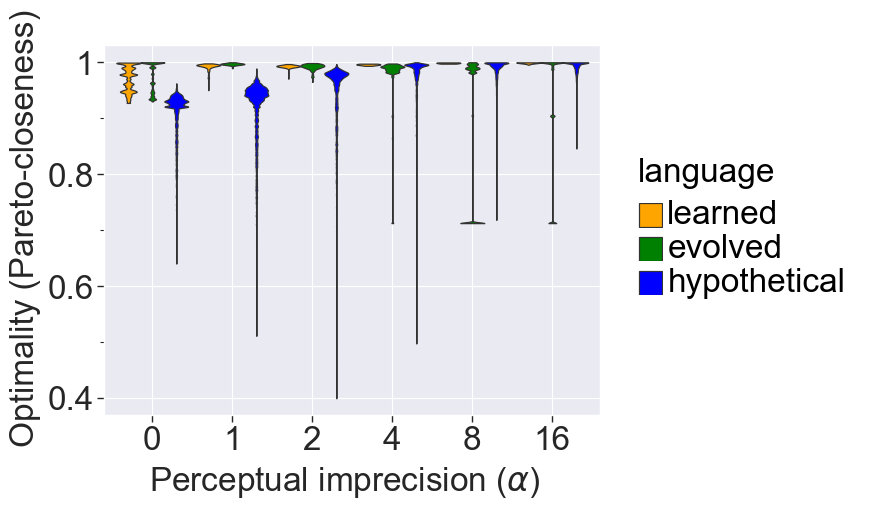

In [52]:
# get plotnine violin plot
values = {"learned": "orange", "evolved": "green", "hypothetical": "blue"}

plot = (
    # Set data and the axes
    pn.ggplot(
            data=dynamics_data, mapping=pn.aes(x="alpha", y="optimality")
    )
    + pn.geom_violin(
        data=dynamics_data,
        mapping=pn.aes(
            fill="language", 
            # color="language", 
            ),
        scale="width",
        bw=0.0015,
    )
    # + pn.scale_color_manual(values=values)
    + pn.scale_fill_manual(values=values)
    + pn.xlab("Perceptual imprecision ($\\alpha$)")
    + pn.ylab("Optimality (Pareto-closeness)")
    + pn.theme_seaborn(context='paper')
    + pn.theme(text=pn.element_text(size=24))
)
print(plot)

In [53]:
# save
fn = "optimality.png"
plot.save(filename=fn, width=10, height=10, dpi=300)

## Generate multi-plot figure of trials and trajectories

In [45]:
# extract the trajectory data
rep_trajs = rep_points[rep_points["point_type"] == "trajectory"]
rl_trajs = rl_points[rl_points["point_type"] == "trajectory"]

# including 'counterparts' from B-A optimization
counterpart_data = data[data["dynamic"] == "blahut_arimoto"]
# set the language column for counterparts
counterpart_data["language"] = "optimal \ncounterpart"
counterpart_points = counterpart_data[counterpart_data["point_type"] == "single_trial"]
counterpart_trajs = counterpart_data[counterpart_data["point_type"] == "trajectory"]

# we'll only use the rl data for legend, so just reset that column
rl_emergent["language"] = "emergent"

# set the final rounds
rep_final_round_data = rep_trajs[rep_trajs["round"] == rep_trajs["round"].max()]
rl_final_round_data = rl_trajs[rl_trajs["round"] == rl_trajs["round"].max()]
counterpart_final_round_data = counterpart_trajs[counterpart_trajs["round"] == counterpart_trajs["round"].max()]

rep_final_round_data["language"] = "evolved"
rl_final_round_data["language"] = "learned"

display(rl_trajs)
display(rep_final_round_data)

,index,rate,distortion,beta,alpha,point_type,dynamic,round,optimality
7806,0,0.007064,16.443802,NaN,0,trajectory,reinforcement_learning,0.0,0.999831
7807,1,0.007166,16.439747,NaN,0,trajectory,reinforcement_learning,1.0,0.999827
7808,2,0.007261,16.431988,NaN,0,trajectory,reinforcement_learning,2.0,0.999823
7809,3,0.007324,16.433375,NaN,0,trajectory,reinforcement_learning,3.0,0.999824
7810,4,0.007445,16.423548,NaN,0,trajectory,reinforcement_learning,4.0,0.999821
...,...,...,...,...,...,...,...,...,...
607801,99995,0.017970,15.072813,NaN,16,trajectory,reinforcement_learning,99995.0,0.999571
607802,99996,0.017970,15.072801,NaN,16,trajectory,reinforcement_learning,99996.0,0.999571
607803,99997,0.017970,15.072791,NaN,16,trajectory,reinforcement_learning,99997.0,0.999571
607804,99998,0.017970,15.072789,NaN,16,trajectory,reinforcement_learning,99998.0,0.999571


,index,rate,distortion,beta,alpha,point_type,dynamic,round,optimality,language
614605,199,3.081134,1.724890,NaN,0,trajectory,replicator_dynamic,199.0,0.960420,evolved
614805,199,2.713356,0.368738,NaN,1,trajectory,replicator_dynamic,199.0,0.994117,evolved
615005,199,1.835892,1.129012,NaN,2,trajectory,replicator_dynamic,199.0,0.988785,evolved
615205,199,1.189177,4.232014,NaN,4,trajectory,replicator_dynamic,199.0,0.982123,evolved
615405,199,0.528926,12.670285,NaN,8,trajectory,replicator_dynamic,199.0,0.987319,evolved
615605,199,0.141133,13.628781,NaN,16,trajectory,replicator_dynamic,199.0,0.996620,evolved


#### single trials

In [50]:
# First two subplots: the trials of learning and evolution
margin = {"t":0, "b":150, "l":0, "r":0}

plot_rep = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  
    + pn.geom_point(  # hypothetical langs
        data=rep_variants,
        mapping=pn.aes(shape="language"),
        color="gray",
        size=3,
        alpha=0.1,
    )
    + pn.geom_line(size=1) # pareto data                   
    + pn.geom_jitter( # emergent langs
        data=rep_emergent,
        mapping=pn.aes(
            fill="alpha", 
            shape="language",
            ),
        alpha=0.3,
        size=5,
    )
    + pn.geom_point( # theoretical bound langs last
        data=counterpart_points,
        mapping=pn.aes(
            fill="alpha",
            shape="language",
            ),
        size=5,
    )    
    # + pn.xlab("Complexity $I(S;\hat{S})$")
    # + pn.ylab("Communicative Cost $D[S, \hat{S}]$")
    + pn.ggtitle("Discrete-time Replicator Dynamic")
    + pn.ylab("Emergent Semantic Systems")
    + pn.theme(
                figure_size=(12, 9),
                legend_position='none',
                legend_box='vertical',
                axis_title_x=pn.element_blank(),
                plot_title=pn.element_text(margin=margin),
                axis_title_y=pn.element_text(margin={"t":0, "b":0, "l":0, "r":20})
        )
)

plot_rl = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  
    + pn.geom_point(  # hypothetical langs
        data=rl_variants,
        mapping=pn.aes(shape="language"),
        color="gray",
        size=3,
        alpha=0.1,
    )
    + pn.geom_line(size=1) # pareto data                   
    + pn.geom_jitter( # emergent
        data=rl_emergent,
        mapping=pn.aes(
            fill="alpha", 
            shape="language", 
            ),
        alpha=0.3,
        size=5,
    )
    + pn.geom_point( # theoretical bound langs last
        data=counterpart_points,
        mapping=pn.aes(
            fill="alpha",
            shape="language",
            ),
        size=5,
    )    
    + pn.ggtitle("Roth-Erev Reinforcement Learning")
    # + pn.ylab("Roth-Erev Reinforcement Learning")
    + pn.theme(
                figure_size=(12, 9),
                legend_position='right',
                legend_box='vertical',
                axis_title_x=pn.element_blank(),
                axis_title_y=pn.element_blank(),
                plot_title=pn.element_text(margin=margin),
        )
)

# next two subplots: trajectories
plot_rep_traj = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  
    + pn.geom_point(
        data=rep_variants,
        mapping=pn.aes(shape="language"),
        color="gray",
        size=3,
        alpha=0.1,
    )
    + pn.geom_line(  # simulation langs
        data=rep_trajs,
        mapping=pn.aes(color="alpha"),
        alpha=1.0,
        size=1,
    )
    + pn.geom_line(size=1) # pareto     
    + pn.geom_point(  # final langs
        data=rep_final_round_data,
        mapping=pn.aes(fill="alpha", shape="language"),
        # shape="X",
        size=5,
    ) 
    + pn.geom_point( # theoretical bound langs
        data=counterpart_points,
        mapping=pn.aes(
            fill="alpha",
            shape="language",
            ),
        size=5,
    )               
    + pn.ylab("Mean Trajectories")
    + pn.theme(
                figure_size=(12, 9),
                legend_position='none',
                legend_box='vertical',
                axis_title_x=pn.element_blank(),
                axis_title_y=pn.element_text(margin={"t":0, "b":0, "l":0, "r":20})
        )
)

plot_rl_traj = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  
    + pn.geom_point( 
        data=rl_variants,
        mapping=pn.aes(shape="language"),
        color="gray",
        size=3,
        alpha=0.1,
    )
    + pn.geom_line(  # simulation langs
        data=rl_trajs,
        mapping=pn.aes(color="alpha"),
        alpha=1.0,
        size=1,
    )
    + pn.geom_line(size=1) # pareto
    + pn.geom_point(  # final langs
        data=rl_final_round_data,
        # shape="X",        
        # color="black",
        mapping=pn.aes(fill="alpha", shape="language"),
        size=5,
    )
    + pn.geom_point( # theoretical bound langs
        data=counterpart_points,
        mapping=pn.aes(
            fill="alpha",
            shape="language",
            ),
        size=5,
    )        
    + pn.theme(
                figure_size=(12, 9),
                legend_position='none',
                legend_box='vertical',
                axis_title_x=pn.element_blank(),
                axis_title_y=pn.element_blank(),
        )
)

#### trajectories

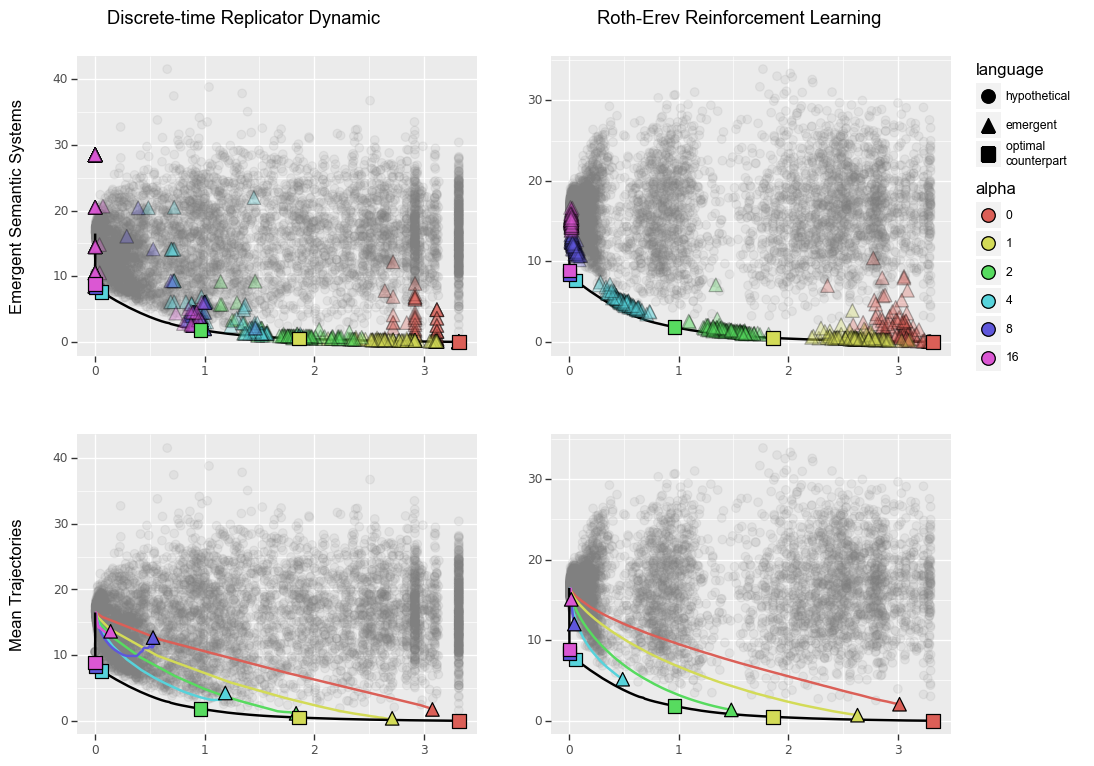

In [51]:
plot_rep = pw.load_ggplot(plot_rep, figsize=(4,3))
plot_rl = pw.load_ggplot(plot_rl, figsize=(4,3))
plot_rep_traj = pw.load_ggplot(plot_rep_traj, figsize=(4,3))
plot_rl_traj = pw.load_ggplot(plot_rl_traj, figsize=(4,3))

g = (plot_rep | plot_rl) / (plot_rep_traj | plot_rl_traj)

g.savefig("multiplot.png")